In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections

df = pd.read_csv('volusia_dataframe.csv')
df


,id,objectid,statefp,countyfp,tractce,blkgrpce,geoid,namelsad,mtfcc,funcstat,...,avg_sfla,avg_aprtot,avg_price,avg_rmbed,nbr_parcels,nbr_housing,pop,crime_rate,avg_hh_income,lstat
0,32,261,12,127,83203,2,1.210000e+11,Block Group 2,G5030,S,...,2663.3,308041.5,356547,3.6,301,558,1428,LOW,93688.0,0.130047
1,1806,508,12,127,82100,1,1.210000e+11,Block Group 1,G5030,S,...,1114.6,58531.3,66471,2.8,21,131,263,HIGH,21563.0,0.878620
2,5144,4440,12,127,82301,3,1.210000e+11,Block Group 3,G5030,S,...,1158.8,99391.1,118591,2.1,35,12,165,HIGH,25083.0,0.842086
3,697,4542,12,127,91026,2,1.210000e+11,Block Group 2,G5030,S,...,1672.9,176236.8,196714,3.2,335,335,902,LOW,57275.0,0.507971
4,5148,4443,12,127,90203,3,1.210000e+11,Block Group 3,G5030,S,...,1356.9,139595.3,164451,2.9,57,201,661,LOW,40625.0,0.680778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,5297,4579,12,127,82703,2,1.210000e+11,Block Group 2,G5030,S,...,1556.9,466339.8,523239,2.6,149,347,431,MED,67969.0,0.396980
285,4692,3949,12,127,80500,2,1.210000e+11,Block Group 2,G5030,S,...,1421.9,203062.9,236990,2.5,201,802,1092,MED,35329.0,0.735745
286,10026,9886,12,127,90400,5,1.210000e+11,Block Group 5,G5030,S,...,1200.2,137053.9,154601,2.7,83,143,292,MED,49667.0,0.586933
287,1787,487,12,127,82507,1,1.210000e+11,Block Group 1,G5030,S,...,1773.4,203532.7,236808,2.9,153,164,341,HIGH,44815.0,0.637291


In [2]:
df = df[df.nbr_crimes != 0] #Remove instances with zero crimes since they are very good quality data
df.loc[df['nbr_crimes'] < 300, 'crime_rate'] = 'HIGH' 
df.loc[df['nbr_crimes'] < 19, 'crime_rate'] = 'LOW'

C:\Users\dnaza\ANACONDA\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\dnaza\ANACONDA\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [3]:
collections.Counter(df.crime_rate)

Counter({'HIGH': 103, 'LOW': 98})

# RANDOM FOREST MODEL

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, plot_precision_recall_curve, classification_report, roc_curve, cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing


In [5]:
df = df.iloc[:,18:].dropna()
y = df['crime_rate']
df = df.drop(['crime_rate', 'nbr_parcels'], axis =1 )
df['CRIME_RATE'] = y #Add crime_rate column to the end (right) of the dataset

In [6]:
#x =  preprocessing.normalize(df.iloc[:,2:-1])
x = df.iloc[:,1:-2]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

In [8]:
param_grid = {
    'max_depth': [80, 95, 110],
    'max_features': [1, 2],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 7, 9],
    'n_estimators': [30, 50, 60]
}

In [9]:
scores = ['recall']

In [10]:
import warnings
warnings.filterwarnings("ignore")

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(), param_grid, cv=10, scoring='%s_macro' % score
    )
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    y_pred = clf.predict(x_test)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
       # print("%0.3f (+/-%0.03f) for %r"
            #  % (mean, std * 2, params))
    
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    print(classification_report(y_test, y_pred))
    print()


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_depth': 110, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 60}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

        HIGH       0.55      0.60      0.57        10
         LOW       0.60      0.55      0.57        11

    accuracy                           0.57        21
   macro avg       0.57      0.57      0.57        21
weighted avg       0.57      0.57      0.57        21




# Confusion Matrix

[[6 4]
 [5 6]]


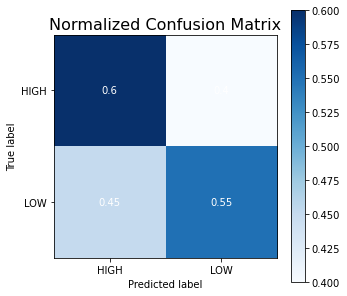

In [11]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize = (5,5), text_fontsize = '10', title_fontsize = '16')
print(confusion_matrix(y_test, y_pred))

# ROC AUC Scores


In [12]:
# Actual class predictions
rf_predictions = clf.predict(x_test)
# Probabilities for each class
rf_probs = clf.predict_proba(x_test)[:, 1]

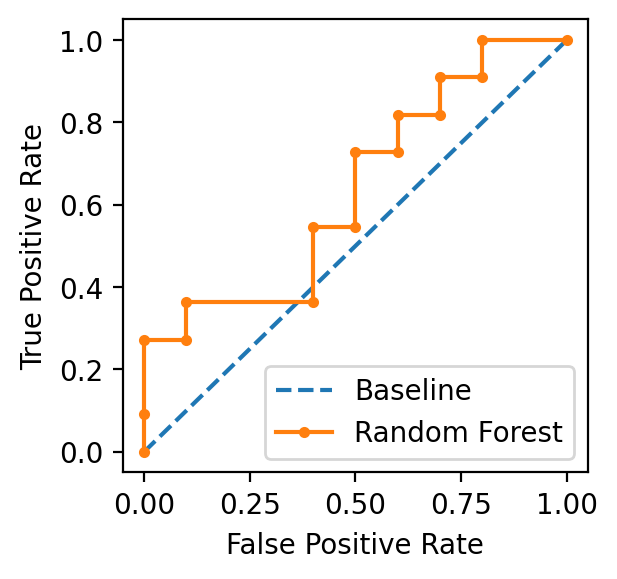

ROC AUC:   0.6363636363636364


In [13]:

# generate a baseline prediction (majority class)
b_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
b_fpr, b_tpr, _ = roc_curve(y_test, b_probs, pos_label = 'LOW')
fpr, tpr, thresh = roc_curve(y_test, rf_probs, pos_label = 'LOW')
# plot the roc curve for the model
plt.figure(figsize=(3,3), dpi = 200)
plt.plot(b_fpr, b_tpr, linestyle='--', label='Baseline')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

print('ROC AUC:  ', roc_auc_score(y_test, rf_probs, average = 'macro'))

# Kappa Statistic


In [14]:
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: ', kappa)

Kappa score:  0.14479638009049778
